In [ ]:
#!pip list
!pip install optuna
!pip install torchmetrics

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
#define class to hold data 

In [ ]:
class WildLife(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.data = []
        self.classes = ["buffalo","elephant", "rhino", "zebra"]          
        
        for animal in os.listdir(root_folder):
            folder = os.path.join(root_folder, animal)
            if not os.path.isdir(folder):
                continue
            
            
            iFiles = sorted([f for f in os.listdir(folder) if f.endswith('.jpg')])

            for imgFile in iFiles:
                textFile = imgFile.replace('.jpg', '.txt')
                textPath = os.path.join(folder, textFile)
                imgPath = os.path.join(folder, imgFile)

                if os.path.exists(textPath) and os.path.exists(imgPath):
                    self.data.append((imgPath, textPath, animal))
                else:
                    print(f"Skipping {imgFile}: file missing")
                    
    def __getitem__(self, idx):
        img_path, label_path, class_name = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        originalWidth, originalHeight = image.size 
        resizedWidth = 256
        resizedHeight = 256  
        boxes = []
        labels = []
        
        with open(label_path, "r") as file:
            for line in file:
                values = list(map(float, line.strip().split()))
                class_id = int(values[0]) 
                cx, cy, bw, bh = values[1:] 
                
                # Convert YOLO to pascalVOC
                xmin = (cx - bw / 2) * originalWidth
                ymin = (cy - bh / 2) * originalHeight
                xmax = (cx + bw / 2) * originalWidth
                ymax = (cy + bh / 2) * originalHeight

                
                scaleW = resizedWidth / originalWidth
                scaleH = resizedHeight / originalHeight
    
                xmin = xmin * scaleW
                ymin = ymin * scaleH
                xmax = xmax * scaleW
                ymax = ymax * scaleH
                
                xmin, ymin, xmax, ymax = max(0, xmin), max(0, ymin), min(resizedWidth, xmax), min(resizedHeight, ymax)

                
                if xmax > xmin and ymax > ymin:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(class_id + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        
        if len(boxes) == 0:
            print(f"invalid boxes for {img_path}, skipping image.")
            return self.__getitem__((idx + 1) % len(self.data))

        target = {"boxes": boxes, "labels": labels}
        
        if self.transform:
            image = self.transform(image)
        #print(f"Image path: {img_path}")
        #print(f"Annotation path: {label_path}")
        #print(f"Image size: {image.size}")
        #print(f"Target: {target}")
        return image, target 
    
    def __len__(self):
        return len(self.data)


    #basic structure adapted from https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
    #advice from AI helpers input was addapted to hlep with validating bounding box data was corectly readin and formatted correctly 

In [23]:
pwd

'C:\\Users\\ninja\\Documents\\CMP511\\assessment'

In [ ]:
DEVICE = torch.device("cpu")
BATCHSIZE = 4
CLASSES = 5
DIR = os.getcwd()
EPOCHS = 1
NUMTRAINEXAMPLES = BATCHSIZE * 30
NUMVALIDEXAMPLES = BATCHSIZE * 10

def collate(batch):
    batch = [b for b in batch if b is not None]

    if len(batch) == 0:
        print("skipping Empty batch")
        return None
    return tuple(zip(*batch))
        
def get_data():
    transformTrain = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.GaussianBlur(9, sigma=(0.1, 0.5)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue= 0.1),
        #transforms.RandomRotation(10),
        #transforms.RandomHorizontalFlip(0.5),
        #transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    transformTest = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    TrainDataset = WildLife('archive', transform=transformTrain)
    TestDataset = WildLife('test', transform=transformTest)

    trainLoader = DataLoader(TrainDataset, batch_size=2, shuffle=True, collate_fn=collate)
    validLoader = DataLoader(TestDataset, batch_size=1, shuffle=False, collate_fn=collate)

   
    #print(f"training samples: {len(TrainDataset)}")
    #print(f"val samples: {len(TestDataset)}")

    return trainLoader, validLoader




def objective(trial):

    num_classes = 5
    model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=num_classes, weights_backbone='DEFAULT', trainable_backbone_layers=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer)(model.parameters(), lr=lr)
    trainData, valData = get_data()

    for epoch in range(EPOCHS):
        model.train()
        for bid, (data, target) in enumerate(trainData):
            if bid * BATCHSIZE >= NUMTRAINEXAMPLES:
                break

            #print(f"Training batch {bid}:")
            #print(f"Data: {data}")
            #print(f"Target: {target}")
            data = [d.to(device) for d in data]
            target = [{k: v.to(device) for k, v in t.items()} for t in target]
           
            optimizer.zero_grad()
            modelLoss = model(data, target)
            losses = sum(loss for loss in modelLoss.values())
            losses.backward()
            optimizer.step()

        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valData):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= NUMVALIDEXAMPLES:
                    break
                
                #print(f"Validation batch {bid}:")
                #print(f"Data: {data}")
                #print(f"Target: {target}")
                
                
                data = [d.to(device) for d in data]
                target = [{k: v.to(device) for k, v in t.items()} for t in target]
                
                output = model(data)
                predLabels = [o['labels'].cpu()  for o in output]
                trueLabels = [t['labels'].cpu()  for t in target]

                #print(f"Validation batch {bid}:")
                #print(f"Predicted labels: {predLabels}")
                #print(f"True labels: {trueLabels}")

                for pred, true in zip(predLabels, trueLabels):
                    if pred.size(0) == 0 or true.size(0) == 0:
                        continue
                    #print(f"Pred size: {pred.size()}, True size: {true.size()}")
                    minSize = min(pred.size(0), true.size(0))
                    correct += (pred[:minSize] == true[:minSize]).sum().item()

        accuracy = correct / min(len(valData.dataset), NUMVALIDEXAMPLES)
        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

#basic structure of functions adapted from https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py with functions changed to match single model trained later in this notebook
#AI help was adapted to debug objective function to ensure the trials were runing as exspected 

[I 2025-04-03 16:52:49,524] A new study created in memory with name: no-name-ef0b2831-780f-4e36-a446-baab605fa0d6
[I 2025-04-03 16:52:53,604] Trial 0 finished with value: 0.175 and parameters: {'optimizer': 'RMSprop', 'lr': 1.703671635284371e-05}. Best is trial 0 with value: 0.175.
[I 2025-04-03 16:52:56,886] Trial 1 finished with value: 0.0 and parameters: {'optimizer': 'RMSprop', 'lr': 7.71248541503153e-05}. Best is trial 0 with value: 0.175.
[I 2025-04-03 16:53:00,213] Trial 2 finished with value: 0.0 and parameters: {'optimizer': 'SGD', 'lr': 0.07497939517377206}. Best is trial 0 with value: 0.175.
[I 2025-04-03 16:53:03,402] Trial 3 finished with value: 0.0 and parameters: {'optimizer': 'Adam', 'lr': 0.004308198821460154}. Best is trial 0 with value: 0.175.
[I 2025-04-03 16:53:06,747] Trial 4 finished with value: 0.0 and parameters: {'optimizer': 'RMSprop', 'lr': 0.000627878919846315}. Best is trial 0 with value: 0.175.
[I 2025-04-03 16:53:10,152] Trial 5 finished with value: 0.0 

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  0
  Number of complete trials:  100


C:\Users\1903299\AppData\Local\Temp\ipykernel_20944\2424787305.py:17: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


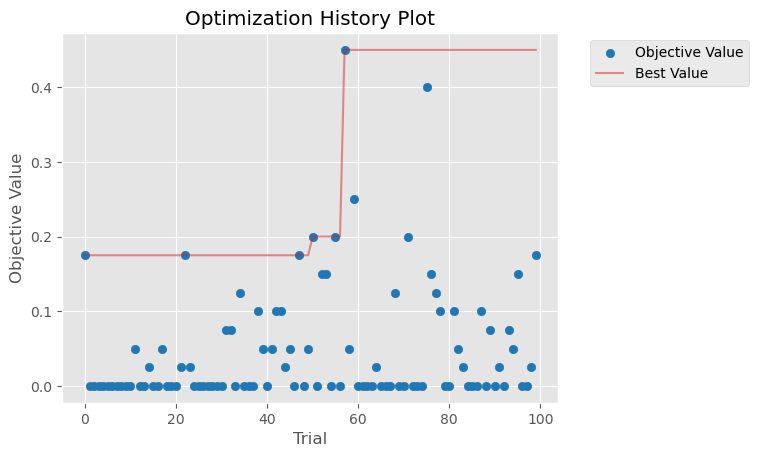

Best trial:
  Value:  0.45
  Params: 
    optimizer: Adam
    lr: 4.886872904809749e-05


In [ ]:
import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history
import torch.optim as optim

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1000)

prunedTrials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
completeTrials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
trial = study.best_trial

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(prunedTrials))
print("  Number of complete trials: ", len(completeTrials))

optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('Optuna study results.png')
plt.show()


print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for paramiter, value in trial.params.items():
    print("{}: {}".format(paramiter, value))

1424
356


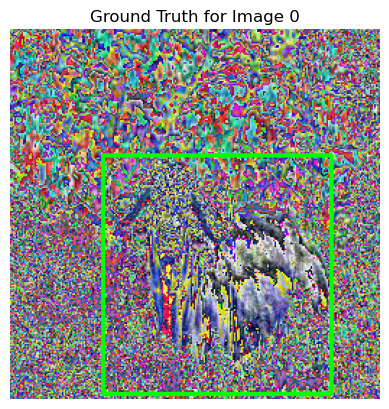

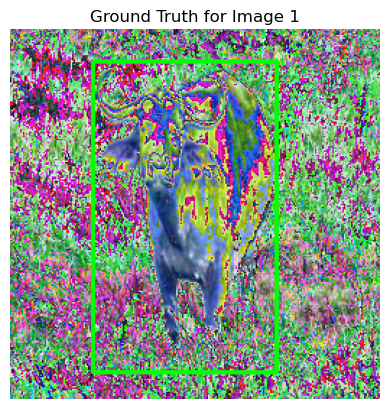

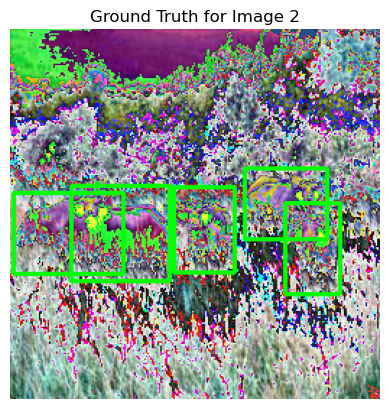

In [ ]:
transformTrain = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.GaussianBlur(9, sigma=(0.1, 0.5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue= 0.1),
    #transforms.RandomRotation(10),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformTest = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainDataset = WildLife('archive', transform=transformTrain)
print(len(trainDataset))
#print(trainDataset)

#for i in range(len(trainDataset)):
#    img, target = trainDataset[i]
#    print(f"Image {i}: {img.shape}, Boxes: {target['boxes']}")
    
TestDataset = WildLife('test', transform=transformTest)
#print(len(TestDataset))
#print(TestDataset)

def collate(batch):
    batch = [b for b in batch if b is not None]  
    if len(batch) == 0:
        print("Skipping Empty batch")
        return None  

     
    #print(f"Batch size: {len(batch)}")
    #for i, b in enumerate(batch):
    #    print(f"Batch item {i}: {b}")

    return tuple(zip(*batch))

trainData = DataLoader(TestDataset, batch_size=4, shuffle=True, collate_fn=collate)
testData = DataLoader(TestDataset, batch_size=1, shuffle=False, collate_fn=collate)
print(len(trainData))

#for images, targets in dataloader_train:
   # print(images[0].shape)  # (3, 256, 256)
   # print(targets[0])  # {'boxes': tensor([...]), 'labels': tensor([...])}



for i in range(3):  
    img, target = trainDataset[i]
    imgNP = img.permute(1, 2, 0).numpy() * 255
    imgNP = imgNP.astype(np.uint8)


    imgNP = cv2.cvtColor(imgNP, cv2.COLOR_RGB2BGR)

    for box in target['boxes']:
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        cv2.rectangle(imgNP, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)


    imgNP = cv2.cvtColor(imgNP, cv2.COLOR_BGR2RGB)
    plt.imshow(imgNP)
    plt.axis("off")
    plt.title(f"Ground Truth for Image {i}")
    plt.show()


In [ ]:
#Defining the model

In [ ]:
# Load pre-trained Faster RetinaNet model
num_classes = 5 # all classes plus back ground
model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=num_classes, weights_backbone='DEFAULT', trainable_backbone_layers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
#Training the model

Starting validation...
Epoch [1/10]
Training Loss:108.0401
validation Loss:1.8660
Starting validation...
Epoch [2/10]
Training Loss:159381.9738
validation Loss:1.6498
Starting validation...
Epoch [3/10]
Training Loss:66.5412
validation Loss:1.6252
Starting validation...
Epoch [4/10]
Training Loss:1.6285
validation Loss:1.6217
Starting validation...
Epoch [5/10]
Training Loss:4.1226
validation Loss:1.6183
Starting validation...
Epoch [6/10]
Training Loss:1.9565
validation Loss:1.6144
Starting validation...
Epoch [7/10]
Training Loss:1.6164
validation Loss:1.6140
Starting validation...
Epoch [8/10]
Training Loss:1.6157
validation Loss:1.6134
Starting validation...
Epoch [9/10]
Training Loss:1.6151
validation Loss:1.6128
Starting validation...
Epoch [10/10]
Training Loss:1.6147
validation Loss:1.6128
Training and Validation Complete!


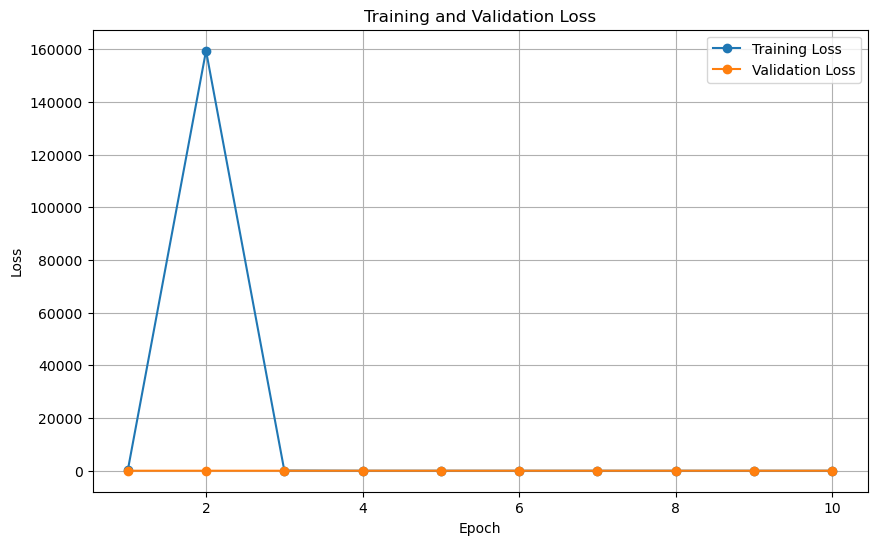

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2.243596823280283e-05, weight_decay=0.0005)
lerningRate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
TrainLoss = []
ValLosses = []
numepochs = 5

for epoch in range(numepochs):
    model.train()
    Eloss = 0
    x=0
    for bid, (images, targets) in enumerate(trainData):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        if all(len(t["boxes"]) == 0 for t in targets):
            continue 

        optimizer.zero_grad()
        Tloss = model(images, targets)
        losses = sum(loss for loss in Tloss.values())

        
        if torch.isnan(losses):
            print("NaN detected, skipping batch")
            continue

        losses.backward()
        optimizer.step()
        #print(x)
        Eloss += losses.item()
        x=x+1
    
    lerningRate.step()
    #print(f"Epoch [{epoch+1}/{numepochs}], Loss: {Eloss}")

    Eloss /= len(trainData)
    TrainLoss.append(Eloss)
    
# Validation Phase
    model.train()
    valLoss = 0 
    print("Starting validation")
    # Freeze BatchNorm and Dropout layers
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.track_running_stats = False  
        if isinstance(module, torch.nn.Dropout):
            module.eval()
        
    with torch.no_grad():
        for bid, (images, targets) in enumerate(testData):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            

            Val_loss_dict = model(images, targets)
            losses = sum(loss for loss in Val_loss_dict.values())
            valLoss += losses.item()
            

    valLoss /= len(testData)
    ValLosses.append(valLoss)
    print(f"Epoch [{epoch+1}/{numepochs}]")
    print(f"Training Loss:{Eloss:.4f}")
    print(f"validation Loss:{valLoss:.4f}")

            # Debug: Print predictions and targets
            #print(f"Validation Batch {batch_idx + 1}:")
            #print(f"Predictions: {predictions}")
            #print(f"Targets: {targets}")

print("Training and Validation Complete")


# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, numepochs + 1), TrainLoss, label="Training Loss", marker='o')
plt.plot(range(1, numepochs + 1), ValLosses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.savefig('Single_training_loss_plot.png')
plt.show()

#Basic training validation structue was adapted from https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/
#AI helper was used to debug if the models training was being compleated. 

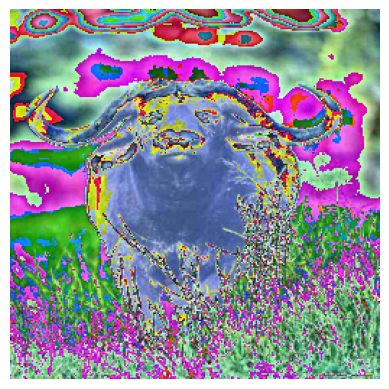

In [ ]:
# show an example prediction 
testImg, _ = TestDataset[0]
testImg = testImg.to(device).unsqueeze(0)


model.eval()
with torch.no_grad():
    pred = model(testImg)

class_name = ["buffalo","elephant", "rhino", "zebra"]
for i, box in enumerate(pred[0]['boxes']):
    score = pred[0]['scores'][i].item()
    pre = pred[0]['labels'][i].item() -1 
    print(f"Box: {box}, score: {score}")
    print(f"correct class: buffalo, prediction: {class_name[pre]}")

#print(predictions)

imgNP = testImg.squeeze(0).cpu().permute(1, 2, 0).numpy()
imgNP = (imgNP * 255).astype(np.uint8)

#print(imgNP.shape)


imgNP = cv2.cvtColor(imgNP, cv2.COLOR_RGB2BGR)

# Draw predictions
for i, box in enumerate(pred[0]['boxes']):
    score = pred[0]['scores'][i].item()
    #print(box)
    #print(score)
    if score > 0.5:
        print('higher than 0.5 con')
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        print(xmin, ymin, xmax, ymax)
        startpoint = (int(xmin),int(ymin))

        endpoint = (int(xmax), int(ymax))
        cv2.rectangle(imgNP, startpoint, endpoint,  (0, 255, 0), 2)


imgNP = cv2.cvtColor(imgNP, cv2.COLOR_BGR2RGB)
plt.imshow(imgNP)
plt.axis("off")
plt.savefig('model prediction test.png')
plt.show()

In [ ]:
#model evaluation 

In [ ]:
#evaluation functions


In [ ]:
def cal_IOU(box1, box2): #calculates IOU 
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    ovelapping = area1 + area2 - intersection

    return intersection / ovelapping if ovelapping > 0 else 0

#IOU function adapted from https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [ ]:
#start evaluation
model.eval()
trueLabels = []
predLabels = []
predictions = {}
truths = []
IOUthreshold = 0.9

In [ ]:
with torch.no_grad():
    for images, targets in testData:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            TBoxes = targets[i]["boxes"].tolist()
            Tlabels = targets[i]["labels"].tolist()
            Pboxes = output["boxes"].tolist()
            Plabels = output["labels"].tolist()
            Pscores = output["scores"].tolist()


            predictions[i] = (Pboxes, Pscores)
            truths.append(TBoxes)
            print(f"GT Labels: {len(Tlabels)}, Pred Labels: {len(Plabels)}")
            trueLabels.extend(Tlabels)

            # Assigning labels based on IOU
            for Tbox, Tlabel in zip(TBoxes, Tlabels):
                bestIOU = 0
                matchedPlabel = 0
                for pbox, plabel in zip(Pboxes, Plabels):
                    iou = cal_IOU(pbox, Tbox)
                    if iou > bestIOU and iou > IOUthreshold:
                        bestIOU = iou
                        matchedPlabel = plabel

                trueLabels.append(Tlabel)
                predLabels.append(matchedPlabel)

            # Handle false positives
            for Pbox, Plabel in zip(Pboxes, Plabels):
                bestIOU = 0
                for tbox in TBoxes:
                    iou = cal_IOU(Pbox, tbox)
                    if iou > bestIOU:
                        bestIOU = iou

                if bestIOU < IOUthreshold:
                    trueLabels.append(0)
                    predLabels.append(Plabel)


        print(f"Length of true labels: {len(trueLabels)}")
        print(f"Length of pred labels: {len(predLabels)}")

# Compute metrics
precision = precision_score(trueLabels, predLabels, average='weighted', zero_division=1)
recall = recall_score(trueLabels, predLabels, average='weighted', zero_division=1)
f1 = f1_score(trueLabels, predLabels, average='weighted')
MAPscores = MeanAveragePrecision()
MAPscores.update(predictions, truths)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1:}")
print(MAPscores)


cm = confusion_matrix(trueLabels, predLabels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Buffalo", "Elephant","Rhino", "Zebra", "Background"], yticklabels=["Buffalo", "Elephant","Rhino", "Zebra", "Background"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

GT Labels: 1, Pred Labels: 2
Length of all_true_labels: 3
Length of all_pred_labels: 2
GT Labels: 4, Pred Labels: 24
Length of all_true_labels: 35
Length of all_pred_labels: 30
GT Labels: 1, Pred Labels: 3
Length of all_true_labels: 39
Length of all_pred_labels: 33
GT Labels: 1, Pred Labels: 3
Length of all_true_labels: 43
Length of all_pred_labels: 36
GT Labels: 1, Pred Labels: 3
Length of all_true_labels: 46
Length of all_pred_labels: 38
GT Labels: 1, Pred Labels: 4
Length of all_true_labels: 51
Length of all_pred_labels: 42
GT Labels: 4, Pred Labels: 18
Length of all_true_labels: 71
Length of all_pred_labels: 58
GT Labels: 1, Pred Labels: 3
Length of all_true_labels: 76
Length of all_pred_labels: 62
GT Labels: 4, Pred Labels: 16
Length of all_true_labels: 98
Length of all_pred_labels: 80
GT Labels: 1, Pred Labels: 6
Length of all_true_labels: 104
Length of all_pred_labels: 85
GT Labels: 2, Pred Labels: 8
Length of all_true_labels: 115
Length of all_pred_labels: 94
GT Labels: 2, Pred

ValueError: Found input variables with inconsistent numbers of samples: [392, 320]